# Taking Netflix By Storm: The Correlation between Watching and the Weather

TODO:
* Seperate code into utils/project specific
* More Data Aggregation
    * Data dispersion display for each temp category
    * /Precipitation Hypo Test  
* Classification
    * /kNN
    * /Decision Tree
    * /Third Method
* Conclusion
* Create README.md

## Introduction
### A. The Entertainment Domain
My project will take place in the entertainment domain and deal primarily with my Netflix consumption patterns. Netflix and TV shows in general are certainly prevelant in my daily life. In general, I try to be careful about the amount of time I spend watching Netflix and consuming other digital media in order to ensure that I am not forgetting to live my life and that I am not getting addicted to watching certain shows. The entertainment domain is something that I am continuously aware of and trying to track in my everday life. It is certainly important for society as a whole to be looking into this domain, looking at the factors that impact our consumption within this domain, and reflecting on the impact that this domain has on our lives. I am reasearching this domain because I am particularly interested in finding out if factors outside of this domain, in this case weather, can have a significant impact on how much time we spend within the entertainment domain.  


### B. Hypotheses
My hypothesis about this domain is that I will find a correlation between my Netflix viewing habits and the weather. I believe that when the weather is colder, then my total time watching Netflix is above average. In addition to this, I also believe the opposite. When the weather is warmer, my total time watching netflix is below my average. The impact of these results could help me in the long run as I try to be conscious and limit the amount of time I spend on Netflix. If I am aware that colder weather has an impact on my viewing patterns, it will help me to remember to be more conscious about it on days when the weather is colder. My roommates are also stakeholders in this study due to the fact that I force them to watch Netflix with me in our apartment. If it is true that the weather effects our viewing patterns, then it is effecting my roommates as well as myself. Netflix as a company is also a stakeholder in this. If there are more people using their platform on a given day they need to make sure that everything is running smoothly and quickly. However, on a warmer day when not as many people are watching, it is not as likely that there will be problems on their platform.

## Data Analysis
### A. Dataset Description
The first table that will be used in the dataset is my netflix data table. This table is downloaded from my account on netflix. It is downloaded as a CSV file and contains three different attributes. The first is a categorical, specifically nominal, attribute, it is the name of the TV show/specific episode or movie that I watched. The second is an ordinal attribute, this attribute holds the date that the show or movie was watched. The final attribute for this table is continuous and contains the length of the show or movie that I watched. This attribute was added manually by me after the data was downloaded.    
The second table that I want to join with the first is a data from the MeteoStat API. The documentation about the API can be found at the following URL: https://dev.meteostat.net/docs/. There are three attributes that I will focus on. The first attribute is the date, this is the attribute that I plan to use as the key to merge the two datasets together. The second attribute is an interval attribute and will describe the average temperature in degrees fahrenheit for that date. The third and fourth attributes are ratio attributes, with the third holding the amount of precipitation and snowfall for each date in the table.

### B. Data Preparation
First the netflix data will be pulled from the netflix_viewing_data.csv file.

In [140]:
import pandas as pd
import numpy as np
import py_utils

#load in netflix viewing data
viewing_df = pd.read_csv("netflix_viewing_data.csv")

Now the weather data will be pulled from the MeteoStat API using an API key specific to me. A response will be requested and the information will be be stored in a json object. 

In [141]:
# load in weather data from MeteoStat API
import requests
import json

api_key = "x4OYeAd2RgfD0XS6d6it41PRdVLdPE5C"

# meteostat API requires your API key be in the request headers, not in the url query params
headers = {"x-api-key": api_key}

# step 1: get the spokane weather station
url = "https://api.meteostat.net/v2/stations/search"
# add query params
url += "?query=spokane"

response = requests.get(url=url, headers=headers)
json_object = json.loads(response.text)
data_object = json_object["data"][0]
spokane_id = data_object["id"]


# step #2: use spokane weather station id to get daily weather for all of 2020
url = "https://api.meteostat.net/v2/stations/daily"
# add query params
url += "?station="
url += spokane_id
url += "&start=2020-08-29"
url += "&end=2020-10-30"

response = requests.get(url=url, headers=headers)
json_object = json.loads(response.text)

The weather data has been pulled from the API into the json_object it can now be loaded into a DataFrame.

In [142]:
# create the necessary pandas object to hold the data
data_object = json_object["data"]
# load in data
weather_df = py_utils.load_weather(data_object)

Both data sets will need to be cleaned before they can be merged. In the weather dataset, the precipitation and snow column will be cleaned by replacing the amount of precipitation with either a 0 or a 1 depending on whether or not there was precipitation on a given day. 

In [143]:
#clean precipitation column
precip_ser = weather_df["prec"]

# if rain then 1, if not then 0
for i in range (0, len(precip_ser)):
    if precip_ser[i] > 0:
        precip_ser.replace(precip_ser[i], 1, inplace=True)
weather_df["prec"] = precip_ser

Further cleaning of the weather dataframe is also needed. Using the median temperature (60.8), a new column will be created that captures wether or not a temperature is above or below the median. A temperature will either be assigned "low" or "high" in the "temp cat" column. 

In [144]:
# find median for future split
temp_ser = weather_df["tavg"]
temp_ser.sort_values()
temp_median = temp_ser.median()
print("Median temperature:", temp_median)

# add column to keep track of low/high
temp_ser = weather_df["tavg"] # get the unsorted series
low_high_ser = pd.Series(dtype=int)
for i in range (0, len(temp_ser)):
    if temp_ser[i] < temp_median:
        low_high_ser = low_high_ser.append(pd.Series("Low"))
    elif temp_ser[i] == temp_median or temp_ser[i] > temp_median:
        low_high_ser = low_high_ser.append(pd.Series("High"))
        
weather_df["temp cat"] = low_high_ser.values
weather_df.to_csv("spokane_weather_clean_data.csv")

Median temperature: 60.8


The netflix dataset will now be cleaned. Rather than add the current DataFrame which includes each individual show title and watch time, I will create a new dataframe that only includes the date and the total watch time for that particular date. This new dataframe will be the one merged with the Spokane weather dataframe that was cleaned above. In order to do so, each date in the dataset will be put in a new dataframe in the format yyyy-mm-dd with no repeats in the dataframe.

In [145]:
date_col = viewing_df["Date"] #get date column
time_col = viewing_df["Length"] #get length column
total_watch_df = pd.DataFrame() #create new df

# create new series to add to df
dates_no_repeats = pd.Series(dtype=int)
total_watch_ser = pd.Series(dtype=int)

# add each date to the dates_no_repeats sereis
for i in range (8, 11):
    for j in range(1,32):
        if i == 8 and j >= 29:
            date_str = "2020-0" + str(i) + "-" + str(j)
            dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))
        elif i == 9:
            if j < 31: 
                if j < 10:
                    date_str = "2020-0" + str(i) + "-0" + str(j)
                else: 
                    date_str = "2020-0" + str(i) + "-" + str(j)
                dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))
        elif i == 10:
            if j < 31: 
                if j < 10:
                    date_str = "2020-" + str(i) + "-0" + str(j)
                else: 
                    date_str = "2020-" + str(i) + "-" + str(j)
                dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))

date_col = dates_no_repeats.values
total_watch_df["Date"] = dates_no_repeats.values # add to the df
date_ser = total_watch_df["Date"] # get the column from the df 

Finally, the total amount of time spent watching netflix on each respective date will be added to the new dataframe. 

In [146]:
# add 0s to each value in total_watch_ser
for i in range (len(total_watch_df["Date"])):
    total_watch_ser = total_watch_ser.append(pd.Series(0))

total_watch_df["Viewing Time"] = total_watch_ser.values # add to the df
watch_ser = total_watch_df["Viewing Time"].copy() # get the column for use below

# add total times to each date
for i in range(len(date_col)):
    date = date_col[i] # get date from old df
    for j in range(0, len(total_watch_df["Date"])):
        target_date = date_ser[j] # target date from new df
        if date == target_date:
            new_num = watch_ser[j] + time_col[i] # add current value to new value for each date
            watch_ser[j] = new_num # set equal to new value
            #total_watch_df.loc["Viewing time", j] = new_num
            
total_watch_df["Viewing Time"] = watch_ser.values 

Now that the two datasets are cleaned, they need to be merged. In the code cell below, the weather_df that contains the date, average temperature, precipation, and temp category will be merged with the total_watch_df that contains the date and total viewing time for that date. These two dataframes will be merged on the "Date" category and written to a csv file named "merged_netflix_viewing_weather.csv". 

In [147]:
# join the two datasets together
merged_netflix_weather_df = total_watch_df.merge(weather_df, on="Date")
merged_netflix_weather_df.to_csv("merged_netflix_viewing_weather.csv")

### C. Exploratory Data Analysis
The data has now been loaded, cleaned, and merged. At this point the exploratory data analysis and in depth data aggregation can begin. Before moving into more complex data aggregation techniques, I want to first show the initial relationship between the temperature and the number of minutes watched. This will be done directly below using a scatter plot that compares the viewing time (y axis) to the temperature (x axis). 

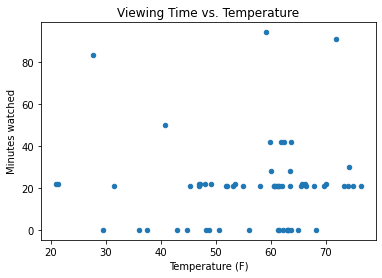

In [148]:
# create a scatter plot showing the initial relationship between the two data sets
import numpy as np
import matplotlib.pyplot as plt

py_utils.scatter_plot(merged_netflix_weather_df)

The scatter plot above does not clearly show a relationship between the temperature and the number of minutes watched. In order to get a clearer picture of the meaning behind and the answer to our hypotheses, more data aggregation and relationship tests will need to be computed.  
The next visualization will be between the precipitation and the amount of time viewed. This will be done using a bar graph. The blue bar is the mean amount of time watched when there was precipitation reported on that day and the orange bar is the mean amount of time when no precipitation was reported on that day. 

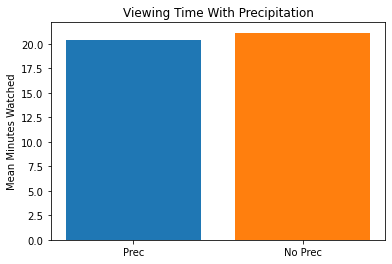

In [149]:
prec_ser = pd.Series(dtype=float)
no_prec_ser = pd.Series(dtype=float)
prec_ser, no_prec_ser = py_utils.graph_bar(merged_netflix_weather_df)

Once again, this graph shows no real relationship between precipitation and the amount of time spent watching netflix. To ensure that this is actually the case, further investigation is necessary. 

In dorder to continue perfomring data aggregation on the dataset, the data will undergo a split based on the "Temp Category" column. All of the dates with a "Low" category will be gathered into a dataframe while all of the dates with a "High" category will be gathered into a different dataframe. After this, the mean and standard deviation will be calculated for each group.

In [150]:
# split the dataset
low_temp_df = pd.DataFrame()
high_temp_df = pd.DataFrame()
grouped_by_temp_category = merged_netflix_weather_df.groupby("temp cat")
for group_name, group_df in grouped_by_temp_category:
    if group_name == "Low":
        low_temp_df = group_df
    elif group_name == "High":
        high_temp_df = group_df

# find mean viewing time of both groups
viewing_time_low_ser = low_temp_df["Viewing Time"]
viewing_time_high_ser = high_temp_df["Viewing Time"]
print("Mean of low category", viewing_time_low_ser.mean())
print("Mean of high category", viewing_time_high_ser.mean())
print()

# find the standard deviation of each group
print("Standard deviation of low category", viewing_time_low_ser.std())
print("Standard deviation of high category", viewing_time_high_ser.std())

Mean of low category 21.322580645161292
Mean of high category 19.84375

Standard deviation of low category 21.967228768894504
Standard deviation of high category 18.212206780246362


Looking at these raw stats from above, the mean of the low temperature is higher than the mean of the high category, however, the standard deviation of the low category is larger than the mean of the low category. To get a better sense of where the mean of each category confidence intervals will be computed for each category. Using the above mean and standard deviation of each temperature category, the confidence intervals will be computed. These confidence intervals will be found at 95%. 

In [151]:
# Find the Confidence Interval at 95%

#low weather 
Xbar_low = viewing_time_low_ser.mean()
std_low = viewing_time_low_ser.std()
n = len(viewing_time_low_ser)
t = 2.000

margin_of_error = t * std_low / np.sqrt(n)
conf_interval_low_temp = (Xbar_low - margin_of_error, Xbar_low + margin_of_error)
print("Low temp confidence interval:", conf_interval_low_temp)

#high weather 
Xbar_high = viewing_time_high_ser.mean()
std_high = viewing_time_high_ser.std()
n = len(viewing_time_high_ser)
t = 2.000

margin_of_error = t * std_high / np.sqrt(n)
conf_interval_high_temp = (Xbar_high - margin_of_error, Xbar_high + margin_of_error)
print("High temp confidence interval:", conf_interval_high_temp)

Low temp confidence interval: (13.43171912970418, 29.213442160618406)
High temp confidence interval: (13.40476254265809, 26.28273745734191)


The confidence intervals for each group have a very large range. In order to better show this relationship, the confidence interval for each will be shown in a graph below. 

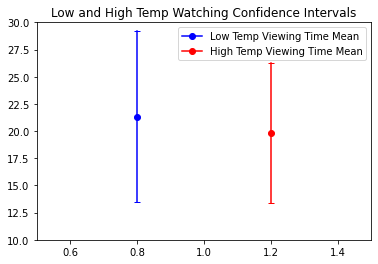

In [152]:
py_utils.confidence_interval_graph(conf_interval_low_temp, Xbar_low, conf_interval_high_temp, Xbar_high)

As shown in the graph above, both temp categories have a fairly large confidence interval. At first glance, it appears that the low temp viewing mean could be higher than the high temp viewing mean but overall it does not look like there will be significant statistical difference between the two. This first glance analysis will be the basis of our first hypothesis test. 

#### Hypothesis Testing
For this particular statistical hypothesis test, a 2 sample, independent, right tailed test to find out if I watched more netflix when the temperature was below 75 degrees (low category) than when the temperature was greater than or equal to 75 degrees (High category). We will be using a significance level of .05.

Step 1:  
$H_0: \mu_1 \leq \mu_2$  
$H_0: \mu_1 > \mu_2$

Step 2:  
$\alpha = .05$

Step 3:  
The appropriate t-test:  
$t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ 

Step 4:  
Find t-critical:  
* right tailed
* $\alpha = .05$
* ddof = $n_1 + n_2 - 2$ = 31 + 31 - 2 = 60

t-critical = 1.671

Decision rule:  
* If t-computed is > 1.671 then reject $H_0$  
* If t-computed is $\leq$ 1.671 then do not reject $H_0$

Step 5:  
t-test:  
$t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ 

In the code cell below the SciPy method ttest_ind() will be used to compute the above formula:

In [153]:
import scipy.stats as stats

t_value, p_value = stats.ttest_ind(viewing_time_low_ser.tolist(), viewing_time_high_ser.tolist())
print(t_value)

0.29127447793079436


Since t-computed (.2913) is less than t-critical (1.671):
* Do not reject $H_0$
    * $\mu_1 \leq \mu_2$
* Cannot accept $H_1$
    * $\mu_1 > \mu_2$
    
This conclusion will be checked using the p-value:

In [154]:
print("p-value:", p_value / 2)

p-value: 0.38591478355639225


Since the p-value (.3859) is greater than $\alpha$ (.05), $H_0$ cannot be rejected.

Conclusion: At the .05 level of significance, we can reasonable assume that the mean netflix time watching when the weather is "low" (less that 75 degrees) is less than or equal to the time spent watching when the weather is "high" (greater than or equal to 60.8 degrees).

I want to compute another hypothesis test, this time based off of the relationship between time watched and if there was precipitation or not on that day. My hypothesis is that the mean time watched on precipitation days is greater than the time spent watching on non precipitation days.

Step 1:  
$H_0: \mu_1 \leq \mu_2$  
$H_0: \mu_1 > \mu_2$

Step 2:  
$\alpha = .05$

Step 3:  
The appropriate t-test:  
$t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ 

Step 4:  
Find t-critical:  
* right tailed
* $\alpha = .05$
* ddof = $n_1 + n_2 - 2$ = 31 + 31 - 2 = 60

t-critical = 1.671

Decision rule:  
* If t-computed is > 1.671 then reject $H_0$  
* If t-computed is $\leq$ 1.671 then do not reject $H_0$

Step 5:  
t-test:  
$t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ 

In the code cell below the SciPy method ttest_ind() will be used to compute the above formula:

In [155]:
import scipy.stats as stats

t_value, p_value = stats.ttest_ind(prec_ser.tolist(), no_prec_ser.tolist())
print("t-value:", t_value)

t-value: 0.11693289941093575


In [156]:
print("p-value:", p_value / 2)

p-value: 0.45364868751616666


Since the p-value (.4536) is greater than $\alpha$ (.05), $H_0$ cannot be rejected.

Conclusion: At the .05 level of significance, we can reasonable assume that the mean netflix time watching when the weather there is precipitation (rain or snow) is not greater than the mean time spent watching netflix on days when there was no netflix. 

Neither of the hypothesis tests showed a statistical reason to think that a certain feature is responsible for determining the amount I watched in a given day. 

### C. Classification
A kNN classification will be performed on the dataset and compared to a Decision Tree Classifier and a ... I do not expect the classifications to be overly accurate due to the assumptions the fact that neither of the hypothesis tests proved to be statistically significant. 

For classification of the dataset, I would like to use all of the weather data in my dataframe, including the tavg, prec, and the temp category in order to find out if I watched more than average or less that average. This will include pulling the viewing time column away from rest of the dataset and making it into a binary classification or either high or low, similarly to what I did with the 'temp cat' column. This will be the first thing that I will do below.

In [157]:
viewing_column = merged_netflix_weather_df["Viewing Time"]
viewing_median = viewing_column.median()
binary_viewing_ser = pd.Series(dtype=float)

for i in range (0, len(viewing_column)):
    if viewing_column[i] < viewing_median:
        binary_viewing_ser = binary_viewing_ser.append(pd.Series(0))
    elif viewing_column[i] == viewing_median or viewing_column[i] > viewing_median:
        binary_viewing_ser = binary_viewing_ser.append(pd.Series(1))
# 0 is below median, 1 is above the median

In this new series, 0 represents a below average viewing day and a 1 represents an above average viewing day. This attribute will be used as the class information and is what will try to be predicted. 

The next preprocessing step that needs to be completed is the temp cat column will be transformed from Strings to numerical data with 0 being high and 1 being low. this will be done using the `preprocessing` module from the `sklearn` class. 

In [158]:
# Convert temp cat to numerical
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

merged_netflix_weather_df["temp cat"] = label_encoder.fit_transform(merged_netflix_weather_df["temp cat"])
# 0 is high, 1 is low

Now the "Viewing time" column that will be used as the classifier will be dropped as well as the "Date" column which is unhelpful when classifying the data.

In [159]:
# get the temp cat column for testing
#temp_cat_ser = merged_netflix_weather_df["temp cat"]
merged_netflix_weather_df.drop("Viewing Time", 1, inplace = True)
merged_netflix_weather_df.drop("Date", 1, inplace = True)

Finally the dataset will be normalized before the classification process begins.

In [160]:
# normalize the values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_netflix_weather_df = scaler.fit_transform(merged_netflix_weather_df)

The kNN classifier is being used to classify the data. First the hold out method is used with random state being 1 for reproducibility. After testing a few different k numbers, 7 produced the highest accuracy at 68.8%.

In [161]:
# hold out method
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(merged_netflix_weather_df, binary_viewing_ser, random_state=1, stratify=binary_viewing_ser)

#kNN
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6875


Just to ensure that this was the best method to use with the kNN classifier, the k Cross Fold method was used producing an accuracy of 66.7% and the random subsampling evaluation metric was used producing an accuracy of 59.7%. The hold out method was certainly the best method to pair with the kNN classifier. 

In [162]:
# k cross fold validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

y_predictions = cross_val_predict(clf, merged_netflix_weather_df, binary_viewing_ser, cv=5)
accuracy = accuracy_score(binary_viewing_ser, y_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666


In [163]:
# Random Subsampling
score = 0
for k in range (1, 10):
    clf = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    score = score + accuracy
    
random_acc = score / 9
print("Accuracy:", random_acc)

Accuracy: 0.5972222222222222


Now the kNN classifier will be compared to two other classifier methods, the first being a Decision Tree Classifier. This will also be with random state = 1 for reproducability.

In [164]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(X_train, y_train)
y_predicted_tree = tree_clf.predict(X_test)
accuracy_tree = tree_clf.score(X_test, y_test)
print("Accuracy:", accuracy_tree)

Accuracy: 0.625


The Decision tree classifier has an accuracy of 62.5% which is not quite as accurate as the kNN classifier seen above. 

The final classifier to be compared to the kNN classifier is a Neural Network classifier from the `sklearn.neural_network` class. This was a new classification method to me, so I used the scikit-learn website to help figure it out. The sit I used can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [165]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state = 1)
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)
accuracy = mlp.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6875


The MLP classifier had an accuracy of 68.8% which is the same percentage as the kNN classifier as above. 

Each classification process was computed using the hold out method and then the prediction was compared to the y_test with the accuracy being printed out. Overall, the MLP and the kNN classifiers worked the best on this dataset with the Decision Tree classifier having a lower accuracy overall. 

Conclusion: Provide a brief conclusion of your project, including a short summary of the dataset you used (and any of its inherent challenges for classification), the classification approach you developed, your classifiers’ performance, and any ideas you have on ways to improve performance. Lastly, describe the potential impacts of your work (including ethical impacts) for the stakeholder’s you described in the introduction.
